In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices
from shapely.geometry import Point, Polygon
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

### 1.1 Data Acquisition & Integration

In [2]:
url = "https://data.cityofchicago.org/resource/xq83-jr8c.csv?$limit=17728"
df_energy = pd.read_csv(url)
df_energy

,data_year,id,property_name,reporting_status,address,zip_code,chicago_energy_rating,exempt_from_chicago_energy_rating,community_area,primary_property_type,...,site_eui_kbtu_sq_ft,source_eui_kbtu_sq_ft,weather_normalized_site_eui_kbtu_sq_ft,weather_normalized_source_eui_kbtu_sq_ft,total_ghg_emissions_metric_tons_co2e,ghg_intensity_kg_co2e_sq_ft,latitude,longitude,location,row_id
0,2021,101671,NaN,Not Submitted,6101 6115 N SEELEY AVE,60659,0.0,False,WEST RIDGE,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,41.990462,-87.706208,"(41.99046172, -87.70620782)",2021-101671
1,2021,101826,Drexel Building,Not Submitted,8136 8142 S DREXEL AVE,60619,0.0,False,CHATHAM,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,41.744013,-87.605499,"(41.74401302, -87.60549928)",2021-101826
2,2021,102323,NaN,Not Submitted,3515 3525 W FRANKLIN BLVD,60624,0.0,False,HUMBOLDT PARK,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,41.880824,-87.723279,"(41.8808242, -87.72327934)",2021-102323
3,2022,256888,NaN,Submitted Data,318 N CARPENTER ST,60607,4.0,False,NaN,Office,...,32.4,61.9,32.8,61.4,311.5,3.0,41.887365,-87.653505,"(41.88736471232649, -87.653505317143)",2022-256888
4,2021,104374,NaN,Not Submitted,6000 N SHERIDAN RD,60660,0.0,False,EDGEWATER,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,41.990901,-87.666607,"(41.99090057, -87.66660744)",2021-104374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17723,2017,251237,1242 Lake Shore Drive,Submitted,1242 N. Lake Shore Drive,60610,NaN,NaN,NEAR NORTH SIDE,Multifamily Housing,...,106.3,140.5,115.8,151.3,1019.8,7.5,41.905310,-87.625533,"(41.90531026, -87.62553343)",2017-251237
17724,2016,251356,Johnson Elem-CPS,Submitted,1504 S Albany Ave,60623,NaN,NaN,NORTH LAWNDALE,K-12 School,...,56.5,92.1,61.4,97.3,286.3,5.1,41.861116,-87.703417,"(41.86111582, -87.70341674)",2016-251356
17725,2018,135082,Standard Club of Chicago,Not Submitted,320 S Plymouth Ct,60604,0.0,False,LOOP,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,41.877690,-87.629011,"(41.87769046, -87.62901128)",2018-135082
17726,2016,106014,Delaware III LLC,Submitted,211 E Delaware Pl,60611,NaN,NaN,NEAR NORTH SIDE,Multifamily Housing,...,64.0,145.7,66.6,151.6,475.7,8.3,41.895793,-87.622480,"(41.89579275, -87.62247957)",2016-106014


In [3]:
url_covered = "https://data.cityofchicago.org/resource/g5i5-yz37.csv?$limit=11460"
df_buildings = pd.read_csv(url_covered)
df_buildings

,building_id,address,zip,cohort_sector,cohort_size,verification_year,community_area_name,community_area_number,ward,latitude,longitude,location
0,251626,4929 N Sawyer Ave,60625,Municipal,"> 50,000 Sq Ft",2025.0,Albany Park,14,33,41.97110,-87.70939,"(41.9711, -87.70939)"
1,250014,2949 E 131st St,60633,Municipal,"> 50,000 Sq Ft",2025.0,Hegewisch,55,10,41.65732,-87.55272,"(41.65732, -87.55272)"
2,105044,2018 2040 W Farwell Ave,60645,Residential,"> 50,000 Sq Ft",2025.0,West Ridge,2,50,42.00880,-87.69503,"(42.0088, -87.69503)"
3,254316,2544 W Montrose Ave,60618,Commercial,"> 50,000 Sq Ft",2027.0,Lincoln Square,4,47,41.94662,-87.70269,"(41.94662, -87.70269)"
4,251445,4619 S Wolcott Ave,60609,Municipal,"> 50,000 Sq Ft",2025.0,New City,61,15,41.80974,-87.67190,"(41.80974, -87.6719)"
...,...,...,...,...,...,...,...,...,...,...,...,...
3688,165606,220 E Chicago Ave,60611,Commercial,"> 250,000 Sq Ft",2026.0,Near North Side,8,2,41.89722,-87.62105,"(41.89722, -87.62105)"
3689,173495,7400 W Touhy,60631,Commercial,"> 50,000 Sq Ft",2026.0,Edison Park,9,41,42.01161,-87.81152,"(42.01161, -87.81152)"
3690,103644,200 N Lasalle Ave,60601,Commercial,"> 250,000 Sq Ft",2026.0,Loop,32,42,41.88608,-87.63304,"(41.88608, -87.63304)"
3691,252084,400 W 95th St,60628,Commercial,"> 50,000 Sq Ft",2025.0,Washington Heights,73,21,41.72088,-87.63412,"(41.72088, -87.63412)"


In [4]:
print("Energy Data Columns:")
print(df_energy.columns)

print("\nCovered Buildings Data Columns:")
print(df_buildings.columns)


Energy Data Columns:
Index(['data_year', 'id', 'property_name', 'reporting_status', 'address',
       'zip_code', 'chicago_energy_rating',
       'exempt_from_chicago_energy_rating', 'community_area',
       'primary_property_type', 'gross_floor_area_buildings_sq_ft',
       'year_built', 'of_buildings', 'water_use_kgal', 'energy_star_score',
       'electricity_use_kbtu', 'natural_gas_use_kbtu',
       'district_steam_use_kbtu', 'district_chilled_water_use_kbtu',
       'all_other_fuel_use_kbtu', 'site_eui_kbtu_sq_ft',
       'source_eui_kbtu_sq_ft', 'weather_normalized_site_eui_kbtu_sq_ft',
       'weather_normalized_source_eui_kbtu_sq_ft',
       'total_ghg_emissions_metric_tons_co2e', 'ghg_intensity_kg_co2e_sq_ft',
       'latitude', 'longitude', 'location', 'row_id'],
      dtype='object')

Covered Buildings Data Columns:
Index(['building_id', 'address', 'zip', 'cohort_sector', 'cohort_size',
       'verification_year', 'community_area_name', 'community_area_number',
       'ward'

In [5]:
df_energy = df_energy.rename(columns={'id': 'building_id'})

In [6]:
merged_data = pd.merge(df_energy, df_buildings, on='building_id', how='inner')
merged_data.to_csv('merged_data.csv', index=False)
print(merged_data.columns)


Index(['data_year', 'building_id', 'property_name', 'reporting_status',
       'address_x', 'zip_code', 'chicago_energy_rating',
       'exempt_from_chicago_energy_rating', 'community_area',
       'primary_property_type', 'gross_floor_area_buildings_sq_ft',
       'year_built', 'of_buildings', 'water_use_kgal', 'energy_star_score',
       'electricity_use_kbtu', 'natural_gas_use_kbtu',
       'district_steam_use_kbtu', 'district_chilled_water_use_kbtu',
       'all_other_fuel_use_kbtu', 'site_eui_kbtu_sq_ft',
       'source_eui_kbtu_sq_ft', 'weather_normalized_site_eui_kbtu_sq_ft',
       'weather_normalized_source_eui_kbtu_sq_ft',
       'total_ghg_emissions_metric_tons_co2e', 'ghg_intensity_kg_co2e_sq_ft',
       'latitude_x', 'longitude_x', 'location_x', 'row_id', 'address_y', 'zip',
       'cohort_sector', 'cohort_size', 'verification_year',
       'community_area_name', 'community_area_number', 'ward', 'latitude_y',
       'longitude_y', 'location_y'],
      dtype='object')


### 1.2 Data Cleaning

In [7]:
merged_data.describe()

,data_year,building_id,chicago_energy_rating,gross_floor_area_buildings_sq_ft,year_built,of_buildings,water_use_kgal,energy_star_score,electricity_use_kbtu,natural_gas_use_kbtu,...,total_ghg_emissions_metric_tons_co2e,ghg_intensity_kg_co2e_sq_ft,latitude_x,longitude_x,zip,verification_year,community_area_number,ward,latitude_y,longitude_y
count,17288.000000,17288.000000,11789.000000,1.725200e+04,14852.000000,15177.000000,1956.000000,12400.000000,1.444900e+04,1.370400e+04,...,14235.000000,14235.000000,17278.000000,17278.000000,17288.000000,17252.000000,17288.000000,17288.000000,17288.000000,17288.000000
mean,2019.331675,187866.227267,2.332471,2.522971e+05,1963.996095,1.441194,5955.852761,59.003306,1.065110e+07,1.183564e+07,...,2403.064756,9.081754,41.882699,-87.653940,60625.933769,2025.622826,27.189149,27.582832,41.882605,-87.654130
std,2.296324,60453.132438,1.506592,4.110496e+05,37.395919,5.566485,10923.072230,27.316008,2.938162e+07,3.012270e+07,...,5781.542926,12.752960,0.069146,0.047766,21.246744,0.986687,20.646649,16.764767,0.069046,0.047502
min,2014.000000,100001.000000,0.000000,8.000000e+03,1845.000000,0.000000,1.000000,1.000000,0.000000e+00,-4.774718e+06,...,0.000000,0.000000,41.648457,-87.913738,60048.000000,2023.000000,1.000000,1.000000,41.651400,-87.905560
25%,2017.000000,125859.000000,1.000000,7.549350e+04,1928.000000,1.000000,1349.250000,38.000000,1.823656e+06,3.152968e+06,...,544.450000,5.600000,41.854606,-87.668298,60610.000000,2025.000000,8.000000,8.000000,41.854590,-87.668300
50%,2020.000000,174289.000000,2.500000,1.220555e+05,1970.000000,1.000000,3168.000000,63.000000,3.912326e+06,5.758273e+06,...,1007.600000,7.200000,41.887917,-87.641449,60618.000000,2025.000000,28.000000,30.000000,41.887690,-87.641610
75%,2021.000000,251547.000000,4.000000,2.649755e+05,2000.000000,1.000000,6852.250000,82.000000,9.324993e+06,1.200313e+07,...,2233.550000,9.800000,41.923947,-87.626777,60642.000000,2027.000000,35.000000,42.000000,41.922660,-87.627000
max,2022.000000,260184.000000,4.000000,9.245333e+06,2021.000000,236.000000,318586.000000,100.000000,1.114458e+09,1.249530e+09,...,173705.500000,834.900000,42.022372,-87.527913,60827.000000,2027.000000,77.000000,50.000000,42.021130,-87.527910


In [24]:
missing_values = merged_data.isna().sum().sort_values(ascending=False)
print("Columns with Missing Values:")
print(missing_values[missing_values > 0])

Columns with Missing Values:
all_other_fuel_use_kbtu                     17234
water_use_kgal                              15332
district_steam_use_kbtu                     11857
district_chilled_water_use_kbtu             11698
chicago_energy_rating                        5499
energy_star_score                            4888
exempt_from_chicago_energy_rating            4572
natural_gas_use_kbtu                         3584
weather_normalized_source_eui_kbtu_sq_ft     3133
weather_normalized_site_eui_kbtu_sq_ft       3133
ghg_intensity_kg_co2e_sq_ft                  3053
total_ghg_emissions_metric_tons_co2e         3053
source_eui_kbtu_sq_ft                        2972
site_eui_kbtu_sq_ft                          2971
electricity_use_kbtu                         2839
property_name                                2501
year_built                                   2436
primary_property_type                        2433
of_buildings                                 2111
community_area       

In [9]:
# Percent of missing data by column 
missing_percentage = (merged_data.isna().sum() / len(merged_data)) * 100
missing_percentage = missing_percentage[missing_percentage > 0].sort_values(ascending=False)
print("Percentage of Missing Data for Each Column (Sorted):")
print(missing_percentage)

Percentage of Missing Data for Each Column (Sorted):
all_other_fuel_use_kbtu                     99.687645
water_use_kgal                              88.685794
district_steam_use_kbtu                     68.585146
district_chilled_water_use_kbtu             67.665433
chicago_energy_rating                       31.808191
energy_star_score                           28.273947
exempt_from_chicago_energy_rating           26.446090
natural_gas_use_kbtu                        20.731143
weather_normalized_source_eui_kbtu_sq_ft    18.122397
weather_normalized_site_eui_kbtu_sq_ft      18.122397
ghg_intensity_kg_co2e_sq_ft                 17.659648
total_ghg_emissions_metric_tons_co2e        17.659648
source_eui_kbtu_sq_ft                       17.191115
site_eui_kbtu_sq_ft                         17.185331
electricity_use_kbtu                        16.421795
property_name                               14.466682
year_built                                  14.090699
primary_property_type        

In [10]:
df_clean = merged_data.dropna(subset=['total_ghg_emissions_metric_tons_co2e', 'natural_gas_use_kbtu', 'electricity_use_kbtu'])

In [11]:
missing_percentage = df_clean.isna().sum() / len(df_clean) * 100
missing_percentage = missing_percentage[missing_percentage > 0].sort_values(ascending=False)
print("\nMissing Data After Cleaning:")
print(missing_percentage)


Missing Data After Cleaning:
all_other_fuel_use_kbtu                     99.747606
water_use_kgal                              88.879816
district_steam_use_kbtu                     61.769728
district_chilled_water_use_kbtu             60.789845
chicago_energy_rating                       31.794225
exempt_from_chicago_energy_rating           30.539678
energy_star_score                           12.983446
property_name                               10.890060
community_area                               1.269394
weather_normalized_site_eui_kbtu_sq_ft       1.002153
weather_normalized_source_eui_kbtu_sq_ft     1.002153
zip_code                                     0.489941
of_buildings                                 0.215277
latitude_x                                   0.051963
longitude_x                                  0.051963
location_x                                   0.051963
verification_year                            0.051963
year_built                                   0.02227

In [12]:
#columns_to_scale = [
#    'electricity_use_kbtu',
#    'natural_gas_use_kbtu',
#    'gross_floor_area_buildings_sq_ft',
    #'total_ghg_emissions_metric_tons_co2e',
#    'ghg_intensity_kg_co2e_sq_ft'
#]

#scaler = StandardScaler()

#df_scaled = merged_data_cleaned.copy()
#df_scaled[columns_to_scale] = scaler.fit_transform(merged_data_cleaned[columns_to_scale])


### 2. Data Analysis & Visualizations

In [13]:
# Summary statistics
summary_stats = df_clean.describe()
print("Summary Statistics:")
print(summary_stats)


Summary Statistics:
          data_year    building_id  chicago_energy_rating  \
count  13471.000000   13471.000000            9188.000000   
mean    2019.138891  188316.298864               2.854811   
std        2.341725   60241.435999               1.125485   
min     2014.000000  100001.000000               0.000000   
25%     2017.000000  127778.000000               2.000000   
50%     2020.000000  174323.000000               3.000000   
75%     2021.000000  251521.000000               4.000000   
max     2022.000000  260184.000000               4.000000   

       gross_floor_area_buildings_sq_ft    year_built  of_buildings  \
count                      1.347100e+04  13468.000000  13442.000000   
mean                       2.630671e+05   1963.766855      1.455587   
std                        4.322770e+05     37.670126      5.514440   
min                        1.633300e+04   1845.000000      0.000000   
25%                        7.811100e+04   1927.000000      1.000000   
50% 

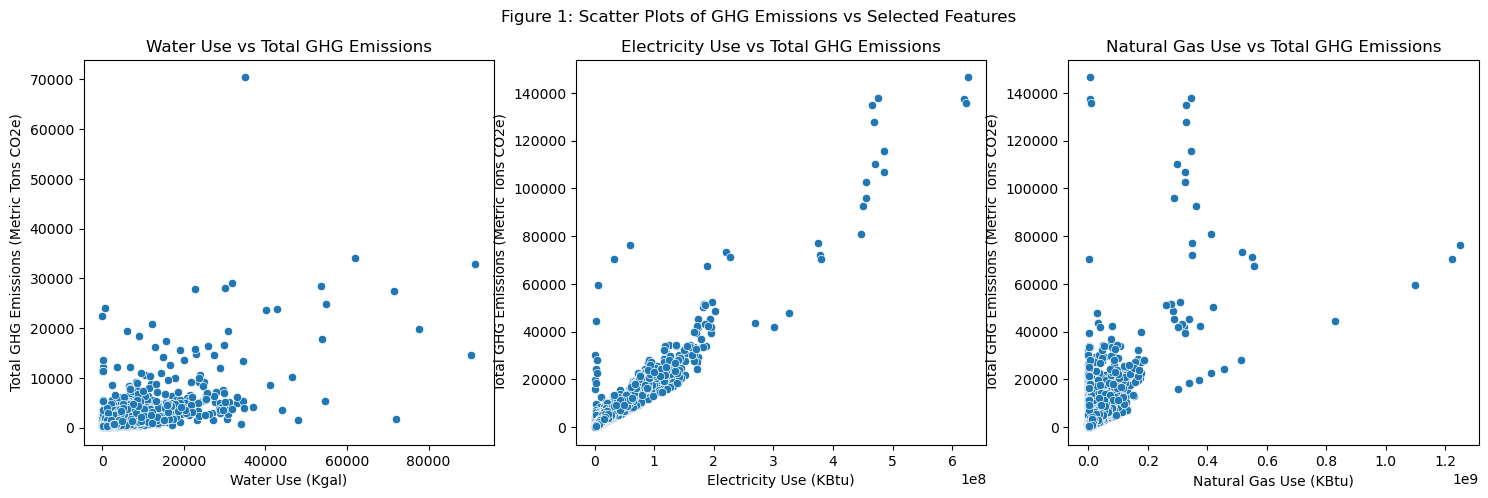

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(x='water_use_kgal', y='total_ghg_emissions_metric_tons_co2e', data=df_clean, ax=axes[0])
axes[0].set_title('Water Use vs Total GHG Emissions')
axes[0].set_xlabel('Water Use (Kgal)')
axes[0].set_ylabel('Total GHG Emissions (Metric Tons CO2e)')

sns.scatterplot(x='electricity_use_kbtu', y='total_ghg_emissions_metric_tons_co2e', data=df_clean, ax=axes[1])
axes[1].set_title('Electricity Use vs Total GHG Emissions')
axes[1].set_xlabel('Electricity Use (KBtu)')
axes[1].set_ylabel('Total GHG Emissions (Metric Tons CO2e)')

sns.scatterplot(x='natural_gas_use_kbtu', y='total_ghg_emissions_metric_tons_co2e', data=df_clean, ax=axes[2])
axes[2].set_title('Natural Gas Use vs Total GHG Emissions')
axes[2].set_xlabel('Natural Gas Use (KBtu)')
axes[2].set_ylabel('Total GHG Emissions (Metric Tons CO2e)')

fig.suptitle('Figure 1: Scatter Plots of GHG Emissions vs Selected Features')
plt.show()

In [15]:
# Correlation analysis
correlation_matrix = df_clean[['water_use_kgal', 'electricity_use_kbtu', 'natural_gas_use_kbtu', 'total_ghg_emissions_metric_tons_co2e']].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)


Correlation Matrix:
                                      water_use_kgal  electricity_use_kbtu  \
water_use_kgal                              1.000000              0.588394   
electricity_use_kbtu                        0.588394              1.000000   
natural_gas_use_kbtu                        0.371382              0.441773   
total_ghg_emissions_metric_tons_co2e        0.610054              0.952838   

                                      natural_gas_use_kbtu  \
water_use_kgal                                    0.371382   
electricity_use_kbtu                              0.441773   
natural_gas_use_kbtu                              1.000000   
total_ghg_emissions_metric_tons_co2e              0.644422   

                                      total_ghg_emissions_metric_tons_co2e  
water_use_kgal                                                    0.610054  
electricity_use_kbtu                                              0.952838  
natural_gas_use_kbtu                          

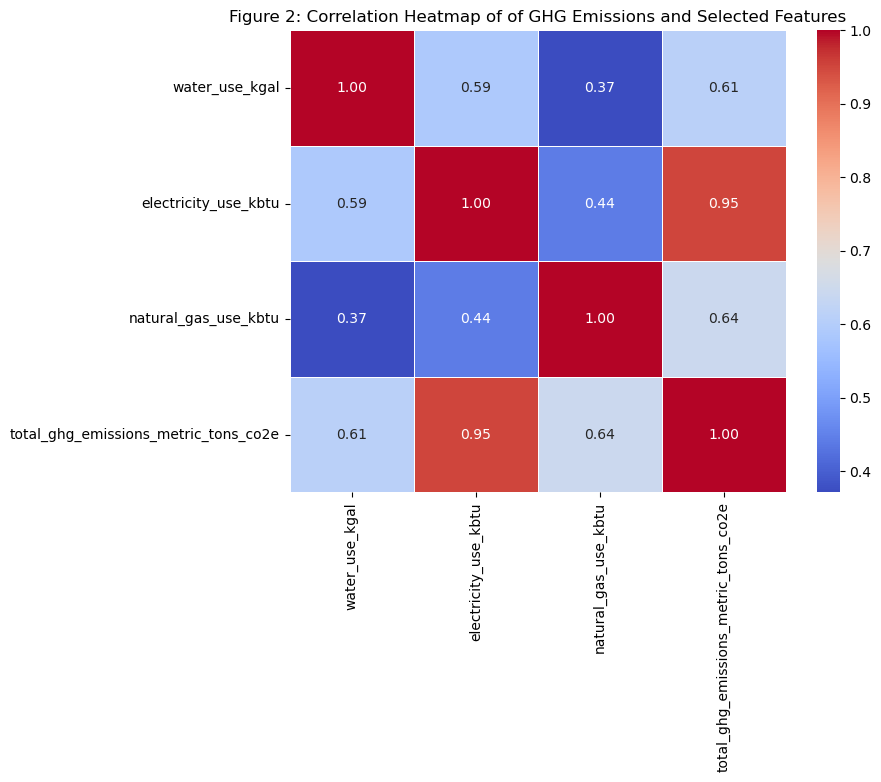

In [16]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Figure 2: Correlation Heatmap of of GHG Emissions and Selected Features')
plt.show()

In [17]:
top_10_community_areas = df_clean['community_area_name'].value_counts().head(5).index
filtered_data = df_clean[df_clean['community_area_name'].isin(top_10_community_areas)]
print("Top 10 Most Common Community Areas:")
print(top_10_community_areas)


Top 10 Most Common Community Areas:
Index(['Near North Side', 'Loop', 'Near West Side', 'Lake View',
       'Lincoln Park'],
      dtype='object', name='community_area_name')


In [18]:
community_areas_count = filtered_data.groupby('community_area_name').count()
community_areas_count

,data_year,building_id,property_name,reporting_status,address_x,zip_code,chicago_energy_rating,exempt_from_chicago_energy_rating,community_area,primary_property_type,...,address_y,zip,cohort_sector,cohort_size,verification_year,community_area_number,ward,latitude_y,longitude_y,location_y
community_area_name,,,,,,,,,,,,,,,,,,,,,
Lake View,866,866,675,866,866,865,618,622,860,866,...,866,866,866,866,866,866,866,866,866,866
Lincoln Park,651,651,559,651,651,651,457,461,644,651,...,651,651,651,651,651,651,651,651,651,651
Loop,1469,1469,1403,1469,1469,1461,947,975,1451,1469,...,1469,1469,1469,1469,1464,1469,1469,1469,1469,1469
Near North Side,2430,2430,2176,2430,2430,2426,1649,1700,2404,2430,...,2430,2430,2430,2430,2430,2430,2430,2430,2430,2430
Near West Side,1125,1125,1010,1125,1125,1115,813,826,1106,1125,...,1125,1125,1125,1125,1125,1125,1125,1125,1125,1125


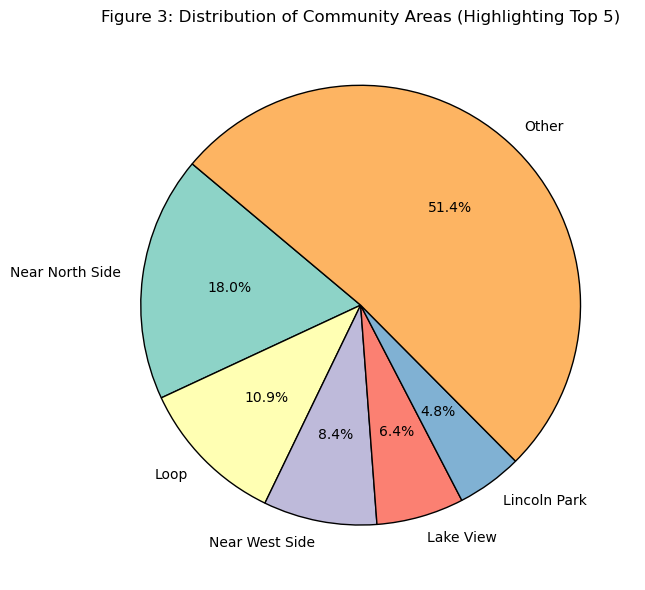

In [19]:
community_counts = df_clean['community_area_name'].value_counts()
top_5_communities = community_counts.head(5)

others_count = community_counts.iloc[5:].sum()
pie_data = top_5_communities.copy()
pie_data['Other'] = others_count

colors = sns.color_palette('Set3', len(pie_data))

plt.figure(figsize=(10, 6))
plt.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops={'edgecolor': 'black'})
plt.title('Figure 3: Distribution of Community Areas (Highlighting Top 5)')
plt.tight_layout()
plt.show()


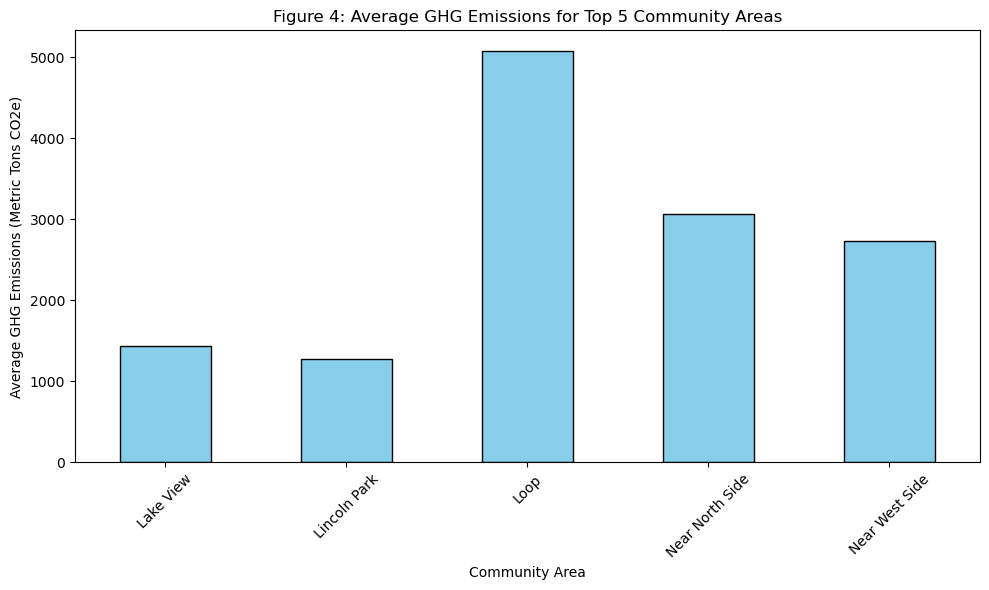

In [25]:
filtered_data = df_clean[df_clean['community_area_name'].isin(top_10_community_areas)]
avg_emissions = filtered_data.groupby('community_area_name')['total_ghg_emissions_metric_tons_co2e'].mean()

colors = sns.color_palette('Set3', len(pie_data))

plt.figure(figsize=(10, 6))
avg_emissions.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Figure 4: Average GHG Emissions for Top 5 Community Areas')
plt.xlabel('Community Area')
plt.ylabel('Average GHG Emissions (Metric Tons CO2e)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
# ANOVA test
grouped_data_top5 = [group['total_ghg_emissions_metric_tons_co2e'].dropna() for _, group in filtered_data.groupby('community_area_name')]
anova_result_top5 = f_oneway(*grouped_data_top5)

print("\nANOVA Test Result for Top 10 Community Areas:")
print(f"F-statistic: {anova_result_top5.statistic}, p-value: {anova_result_top5.pvalue}")


ANOVA Test Result for Top 10 Community Areas:
F-statistic: 75.50543613273797, p-value: 1.1203300865403596e-62


In [26]:
# Post-hoc analysis using Tukey's HSD
tukey = pairwise_tukeyhsd(endog=filtered_data['total_ghg_emissions_metric_tons_co2e'],
                          groups=filtered_data['community_area_name'],
                          alpha=0.05)

print(tukey)

             Multiple Comparison of Means - Tukey HSD, FWER=0.05             
     group1          group2      meandiff  p-adj    lower      upper   reject
-----------------------------------------------------------------------------
      Lake View    Lincoln Park    -160.61 0.9848  -994.1139  672.8939  False
      Lake View            Loop  3644.6625    0.0  2956.2671 4333.0578   True
      Lake View Near North Side  1634.7658    0.0   998.8556 2270.6761   True
      Lake View  Near West Side  1299.0091    0.0   572.6276 2025.3905   True
   Lincoln Park            Loop  3805.2724    0.0  3048.7343 4561.8106   True
   Lincoln Park Near North Side  1795.3758    0.0  1086.2611 2504.4906   True
   Lincoln Park  Near West Side   1459.619    0.0   668.3594 2250.8787   True
           Loop Near North Side -2009.8966    0.0 -2540.9362 -1478.857   True
           Loop  Near West Side -2345.6534    0.0 -2982.2468  -1709.06   True
Near North Side  Near West Side  -335.7568 0.5096  -915.1918  24